In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.utils.data as Data

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# torch.cuda.set_device(0)

import warnings 
warnings.filterwarnings("ignore")

In [3]:
# check CPU or GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('torch version: ', torch.__version__)
print('GPU State:', device)

torch version:  1.4.0
GPU State: cuda:0


In [4]:
# Read Dataset
def read_bci_data():
    S4b_train = np.load('/kaggle/input/eegnet/S4b_train.npz')
    X11b_train = np.load('/kaggle/input/eegnet/X11b_train.npz')
    S4b_test = np.load('/kaggle/input/eegnet/S4b_test.npz')
    X11b_test = np.load('/kaggle/input/eegnet/X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    # Datatype - float32 (both X and Y)
    # X.shape - (#samples, 1, #channels, #timepoints)
    # Y.shape - (#samples)
    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

X_train, y_train, X_test, y_test = read_bci_data()

In [6]:
# EEGNet using Pytorch
class EEGNet(nn.Module):
    def __init__(self, AF=nn.ELU(alpha=1)):
        super(EEGNet, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, 1e-05)
        )      
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, (2, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, 1e-05),
            AF,
            nn.AvgPool2d(kernel_size=(1,4), stride=(1,4), padding=0),
            nn.Dropout(p=0.25)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, 1e-05),
            AF,
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=0.25)
        )
        self.classify = nn.Sequential(
            nn.Linear(in_features=736, out_features=2, bias=True)
        )
        
    def forward(self, x):
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.classify(x.view(len(x), -1))
        return x    
EEGNet()

EEGNet(
  (firstConv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1)
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=736, out_features=2, bias=True)
  )
)

In [7]:
# DeepConvNet using Pytorch
class DeepConvNet(nn.Module):
    def __init__(self, AF=nn.ELU(alpha=1)):
        super(DeepConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=(1, 5), padding=(0, 2), bias=False),
            nn.Conv2d(25, 25, kernel_size=(2, 5), padding=(0, 0), bias=False),
            nn.BatchNorm2d(25, 1e-05),
            AF,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )    
        self.layer2 = nn.Sequential(
            nn.Conv2d(25, 50, kernel_size=(1, 5), padding=(0, 2), bias=False),
            nn.BatchNorm2d(50),
            AF,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(50, 100, kernel_size=(1, 5), padding=(0, 2), bias=False),
            nn.BatchNorm2d(100),
            AF,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(100, 200, kernel_size=(1, 5), padding=(0, 2), bias=False),
            nn.BatchNorm2d(200),
            AF,
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(p=0.5)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=9200, out_features=2)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc(x.view(len(x), -1))
        return x
DeepConvNet()

DeepConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=False)
    (1): Conv2d(25, 25, kernel_size=(2, 5), stride=(1, 1), bias=False)
    (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ELU(alpha=1)
    (4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=False)
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1)
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), bias=False)
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [10]:
# Evaluatoin Function
def evaluate(model, X, y):
    model.eval()
    inputs = Variable(torch.Tensor(X).cuda())
    pred = model(inputs)
    
    return accuracy_score(y, np.array(pred.data.cpu().numpy()).argmax(axis=1))

In [11]:
# Tensor Format Transformation Function
def loader(X, y, batch_size):
    dataset = Data.TensorDataset(torch.Tensor(X), torch.Tensor(y))
    torch.cuda.manual_seed_all(3023)
    return Data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True
    )

In [12]:
# Model Traning
def model_train(net, train, test, epochs, batch_size, scheduler):
    train_acc = []
    test_acc = []

    for epoch in range(epochs+1):  
        net.train(mode=True)
        train_loss = 0.0
        for x, y in train:
            x_batch, y_batch = Variable(x.cuda()), Variable(y.cuda()).long()
            
            optimizer.zero_grad() # zero the parameter gradients
            outputs = net(x_batch) # forward
            loss = criterion(outputs, y_batch) # calculate loss
            loss.backward() # backward
            optimizer.step()
            train_loss += loss.data

        train_acc.append(evaluate(net, X_train, y_train))
        test_acc.append(evaluate(net, X_test, y_test))
        scheduler.step()            

        # accuracy result every 50 epoch
        if epoch % 50 == 0:
            print("\nEpoch ", epoch)
            print("(Training Loss) -", train_loss.data.cpu().numpy())
            print("(Train) - ", evaluate(net, X_train, y_train))
            print("(Test) - ", evaluate(net, X_test, y_test))
            
    return train_acc, test_acc

=== EEGNet start ============================================================

[Activation function] : ReLU ------------------------------

Epoch  0
(Training Loss) - 3.4776247
(Train) -  0.5898148148148148
(Test) -  0.5879629629629629

Epoch  50
(Training Loss) - 1.2118905
(Train) -  0.9351851851851852
(Test) -  0.8342592592592593

Epoch  100
(Training Loss) - 0.85475427
(Train) -  0.9398148148148148
(Test) -  0.8398148148148148

Epoch  150
(Training Loss) - 0.7045229
(Train) -  0.8648148148148148
(Test) -  0.787962962962963

Epoch  200
(Training Loss) - 0.5089529
(Train) -  0.9805555555555555
(Test) -  0.8703703703703703

Epoch  250
(Training Loss) - 0.51083636
(Train) -  0.9898148148148148
(Test) -  0.8629629629629629

Epoch  300
(Training Loss) - 0.53363854
(Train) -  0.9861111111111112
(Test) -  0.8694444444444445

Epoch  350
(Training Loss) - 0.50541353
(Train) -  0.9842592592592593
(Test) -  0.8731481481481481

Epoch  400
(Training Loss) - 0.49360642
(Train) -  0.997222222222222

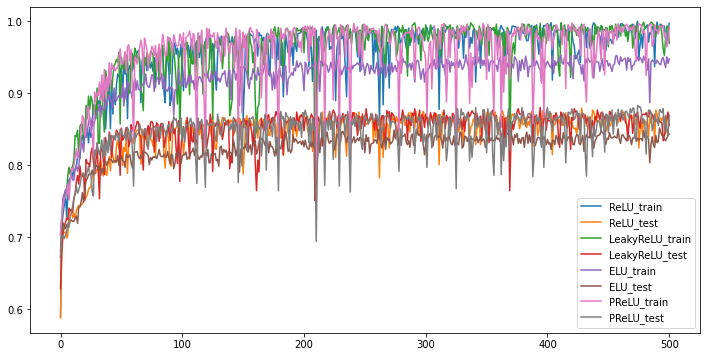

In [25]:
# EEGNet Start
print('=== EEGNet start ============================================================')
plt.figure(figsize=(12, 6))
epochs = 500
batch_size = 256
lr = 0.002
step_size = 150
gamma = 0.9 # gamma of scheduler 
train = loader(X_train, y_train, batch_size)
test = loader(X_test, y_test, batch_size)

activation_box = ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'] # activation function you want to try
train_acc, test_acc = {}, {}
best_train_acc, best_test_acc = {}, {}

for af in activation_box:
    print('\n[Activation function] : %s ------------------------------'%af)
    AF = eval('nn.' + af + '()')
    net = EEGNet(AF=AF).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    train_acc[af+'_train'], test_acc[af+'_test'] = model_train(net, train, test, epochs=epochs, batch_size=batch_size, scheduler=scheduler)
    plt.plot(train_acc[af+'_train'], label=af+'_train')
    plt.plot(test_acc[af+'_test'], label=af+'_test')
    plt.legend()


Epoch  0
(Training Loss) - 20.780901
(Train) -  0.5
(Test) -  0.5

Epoch  50
(Training Loss) - 2.877673
(Train) -  0.7046296296296296
(Test) -  0.6944444444444444

Epoch  100
(Training Loss) - 2.7401888
(Train) -  0.8407407407407408
(Test) -  0.7620370370370371

Epoch  150
(Training Loss) - 1.6531954
(Train) -  0.9212962962962963
(Test) -  0.7953703703703704

Epoch  200
(Training Loss) - 1.2884474
(Train) -  0.9537037037037037
(Test) -  0.7925925925925926

Epoch  250
(Training Loss) - 1.0125117
(Train) -  0.9740740740740741
(Test) -  0.7898148148148149

Epoch  300
(Training Loss) - 0.908512
(Train) -  0.9879629629629629
(Test) -  0.8064814814814815

Epoch  350
(Training Loss) - 0.9056661
(Train) -  0.9953703703703703
(Test) -  0.8046296296296296

Epoch  400
(Training Loss) - 0.59887683
(Train) -  0.9787037037037037
(Test) -  0.7787037037037037

Epoch  450
(Training Loss) - 0.5286133
(Train) -  0.9981481481481481
(Test) -  0.8018518518518518

Epoch  500
(Training Loss) - 0.42788726
(Tr

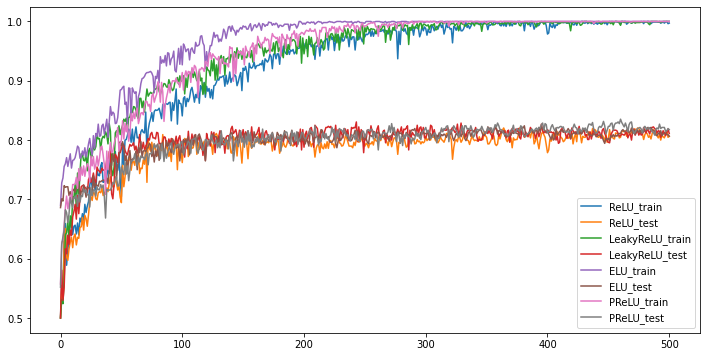

In [26]:
# DeepConvNet Start
plt.figure(figsize=(12, 6))
epochs = 500
batch_size = 256
lr = 0.002
step_size = 150
gamma = 0.9 # gamma of scheduler 
train = loader(X_train, y_train, batch_size)
test = loader(X_test, y_test, batch_size)

activation_box = ['ReLU', 'LeakyReLU', 'ELU', 'PReLU']# activation function you want to try
train_acc, test_acc = {}, {}
best_train_acc, best_test_acc = {}, {}

for af in activation_box:
    AF = eval('nn.' + af + '()')
    net = DeepConvNet(AF=AF).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    train_acc[af+'_train'], test_acc[af+'_test'] = model_train(net, train, test, epochs=epochs, batch_size=batch_size, scheduler=scheduler)
    plt.plot(train_acc[af+'_train'], label=af+'_train')
    plt.plot(test_acc[af+'_test'], label=af+'_test')
    plt.legend()